<a href="https://colab.research.google.com/github/Steveluk270190/Deep-learning-Machine-Learning-project/blob/main/Capstone_project_Span_Email_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes for updates:
- Update to snowball stemmer, seems to be a better version than porter stemmer
    - from nltk.stem import SnowballStemmer 
- Look at the sequence length again for LSTM - maybe around 250-300 is okay? Ask Gabe to run again
- Tidy up preprocessing sections for ML and DL - maybe use same cleaning function for both 
- Quiet warnings on next full run
- KDE plots: put message on one row, subject on another row  **COMPLETE**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/Riya_DL_Project'

/content/drive/MyDrive/Colab Notebooks/Riya_DL_Project


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import re
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
digits = load_digits()
from sklearn.model_selection import train_test_split

# Cleaning and preprocessing data

Read the original dataframe using Pandas.

In [ ]:
df_all = pd.read_csv("./processed_data.csv") #processed_data.csv
df_all.head()

label                                            subject  \
0      1                  Generic Cialis, branded quality@    
1      0                             Typo in /debian/README   
2      1                                   authentic viagra   
3      1                               Nice talking with ya   
4      1  or trembling; stomach cramps; trouble in sleep...   

                          email_to  \
0        the00@speedy.uwaterloo.ca   
1  debian-mirrors@lists.debian.org   
2         <the00@plg.uwaterloo.ca>   
3         opt4@speedy.uwaterloo.ca   
4     ktwarwic@speedy.uwaterloo.ca   

                                          email_from  \
0                 "Tomas Jacobs" <RickyAmes@aol.com>   
1         Yan Morin <yan.morin@savoirfairelinux.com>   
2  "Sheila Crenshaw" <7stocknews@tractionmarketin...   
3       "Stormy Dempsey" <vqucsmdfgvsg@ruraltek.com>   
4         "Christi T. Jernigan" <dcube@totalink.net>   

                                             message  
0  Content-Type: text/html;\nContent-Transfer-Enc...  
1  Hi, i've just updated from the gulus and I che...  
2  Content-Type: text/plain;\n\tcharset="iso-8859...  
3  Hey Billy, \n\nit was really fun going out the...  
4  Content-Type: multipart/alternative;\n        ...

We will focus on using the content of the message from the emails in the dataframe. We drop the `email_to` and `email_from` columns.

In [ ]:
df_all.drop(columns = ['email_to', 'email_from'], inplace=True)

We check for null values, and drop them. We also check for duplicates and drop them.

In [ ]:
df_all.isnull().sum()

label         0
subject     793
message    1487
dtype: int64

In [ ]:
df_all.dropna(inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73211 entries, 0 to 75418
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    73211 non-null  int64 
 1   subject  73211 non-null  object
 2   message  73211 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


There are still over 70k records even after dropping null values. Check for duplicates.

In [ ]:
df_all.duplicated().sum()

10847

There are many duplicate records, which are now dropped to prevent issues in training

In [ ]:
df_all.drop_duplicates(inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62364 entries, 0 to 75418
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    62364 non-null  int64 
 1   subject  62364 non-null  object
 2   message  62364 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


Over 10k duplicate records were dropped. Take a look at the dataframe now.

In [ ]:
df_all.head(10)

label                                            subject  \
0      1                  Generic Cialis, branded quality@    
1      0                             Typo in /debian/README   
2      1                                   authentic viagra   
3      1                               Nice talking with ya   
4      1  or trembling; stomach cramps; trouble in sleep...   
5      1                                      Which is duty   
6      1                                       For Theorize   
7      1  Theorize get inside for local esc0rts who do i...   
8      1                              Losing Weight Quickly   
9      0               [R] Confidence-Intervals.... help...   

                                             message  
0  Content-Type: text/html;\nContent-Transfer-Enc...  
1  Hi, i've just updated from the gulus and I che...  
2  Content-Type: text/plain;\n\tcharset="iso-8859...  
3  Hey Billy, \n\nit was really fun going out the...  
4  Content-Type: multipart/alternative;\n        ...  
5  Content-Type: multipart/alternative;\n        ...  
6  Content-Type: text/plain;\n\tcharset="Windows-...  
7  Content-Type: Multipart/Alternative;\n  bounda...  
8  Content-Type: text/plain;\n    charset="iso-88...  
9  Hi...\n\nI have to use R to find out the 90% c...

The contents in the `message` column are quite messy and require cleaning. Several steps will be used to tidy this column:
* All text will turn into lower case characters
* Rows containing 'Content-Type' will be removed as they contain huge amounts of encoded characters that cannot be efficiently cleaned.
* Replace newline characters with a space 

Note: this is not the end of the text preprocessing, this just a simple cleaning step!

In [ ]:
df_all['message'] = df_all['message'].apply(lambda x: x.lower())
df_all['subject'] = df_all['subject'].apply(lambda x: x.lower())
df_all.head()

label                                            subject  \
0      1                  generic cialis, branded quality@    
1      0                             typo in /debian/readme   
2      1                                   authentic viagra   
3      1                               nice talking with ya   
4      1  or trembling; stomach cramps; trouble in sleep...   

                                             message  
0  content-type: text/html;\ncontent-transfer-enc...  
1  hi, i've just updated from the gulus and i che...  
2  content-type: text/plain;\n\tcharset="iso-8859...  
3  hey billy, \n\nit was really fun going out the...  
4  content-type: multipart/alternative;\n        ...

In [ ]:
# Previous size of dataframe, before removing 'Content-Type' rows
df_all.shape

(62364, 3)

In [ ]:
# New size of dataframe, after removing 'Content-Type' rows 
df_all = df_all[~df_all['message'].str.contains("content-type")]
df_all.shape

(33830, 3)

In [ ]:
# Replacing all \n characters with a space " "
df_all['message_clean'] = df_all['message'].apply(lambda x: re.sub('\n', ' ', x))
df_all['subject_clean'] = df_all['subject'].apply(lambda x: re.sub('\n', ' ', x))
df_all.head()

label                                   subject  \
1       0                    typo in /debian/readme   
3       1                      nice talking with ya   
9       0      [r] confidence-intervals.... help...   
16      1                                    hi man   
19      0  re: [r] confidence-intervals.... help...   

                                              message  \
1   hi, i've just updated from the gulus and i che...   
3   hey billy, \n\nit was really fun going out the...   
9   hi...\n\ni have to use r to find out the 90% c...   
16  hey billy, \n\nit was really fun going out the...   
19  hm... sounds like a homework problem to me...\...   

                                        message_clean  \
1   hi, i've just updated from the gulus and i che...   
3   hey billy,   it was really fun going out the o...   
9   hi...  i have to use r to find out the 90% con...   
16  hey billy,   it was really fun going out the o...   
19  hm... sounds like a homework problem to me... ...   

                               subject_clean  
1                     typo in /debian/readme  
3                       nice talking with ya  
9       [r] confidence-intervals.... help...  
16                                    hi man  
19  re: [r] confidence-intervals.... help...

Once we have completed these basic preprocessing steps, we drop the original subejct and message columns and keep their respective clean columns for use in text classification.

In [ ]:
df = df_all.drop(columns = ['subject', 'message'])
df.head()

label                                      message_clean  \
1       0  hi, i've just updated from the gulus and i che...   
3       1  hey billy,   it was really fun going out the o...   
9       0  hi...  i have to use r to find out the 90% con...   
16      1  hey billy,   it was really fun going out the o...   
19      0  hm... sounds like a homework problem to me... ...   

                               subject_clean  
1                     typo in /debian/readme  
3                       nice talking with ya  
9       [r] confidence-intervals.... help...  
16                                    hi man  
19  re: [r] confidence-intervals.... help...

For the purposes of training, the two columns of `message_clean` and `subject_clean` can be combined to produce a column `content` that contains both the subject and message. 

In [ ]:
df['content'] = df['subject_clean'] + " " + df['message_clean'] 
df.head()

label                                      message_clean  \
1       0  hi, i've just updated from the gulus and i che...   
3       1  hey billy,   it was really fun going out the o...   
9       0  hi...  i have to use r to find out the 90% con...   
16      1  hey billy,   it was really fun going out the o...   
19      0  hm... sounds like a homework problem to me... ...   

                               subject_clean  \
1                     typo in /debian/readme   
3                       nice talking with ya   
9       [r] confidence-intervals.... help...   
16                                    hi man   
19  re: [r] confidence-intervals.... help...   

                                              content  
1   typo in /debian/readme hi, i've just updated f...  
3   nice talking with ya hey billy,   it was reall...  
9   [r] confidence-intervals.... help... hi...  i ...  
16  hi man hey billy,   it was really fun going ou...  
19  re: [r] confidence-intervals.... help... hm......

In [ ]:
# Optional: save the csv file containing the final df 
# df.to_csv("/content/drive/MyDrive/Colab Notebooks/DL Project - 6 9 22/data/cleaned_data.csv")
# df.to_csv("./data/cleaned_data.csv")

# Exploring the dataset 

The final dataset can be explored to look at the text inside the messages and subject lines. We use a word cloud to visualise the most common words in the message and subject lines for both spam (1) and ham (0) categories.

In [ ]:
from wordcloud import WordCloud

(-0.5, 1599.5, 799.5, -0.5)

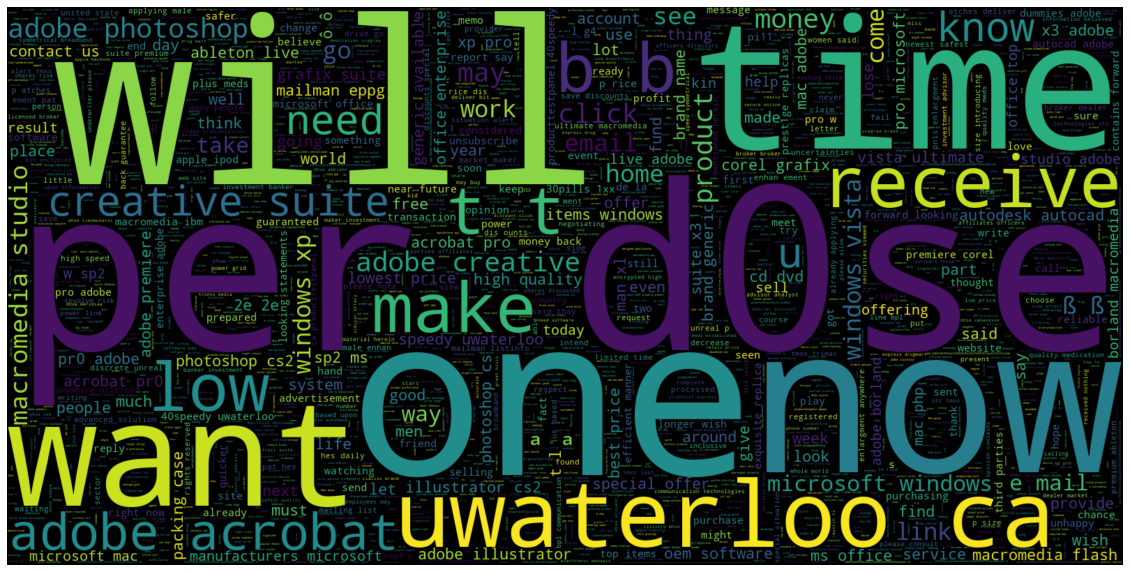

In [ ]:
# Word cloud for spam messages
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 1].message_clean))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

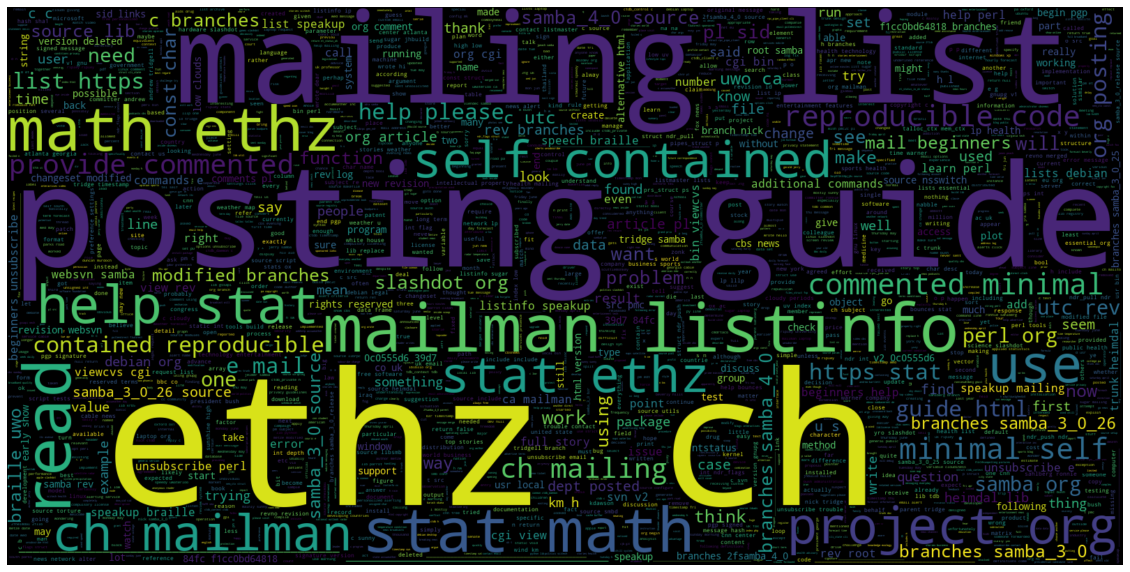

In [ ]:
# Word cloud for not spam messages
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 0].message_clean))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

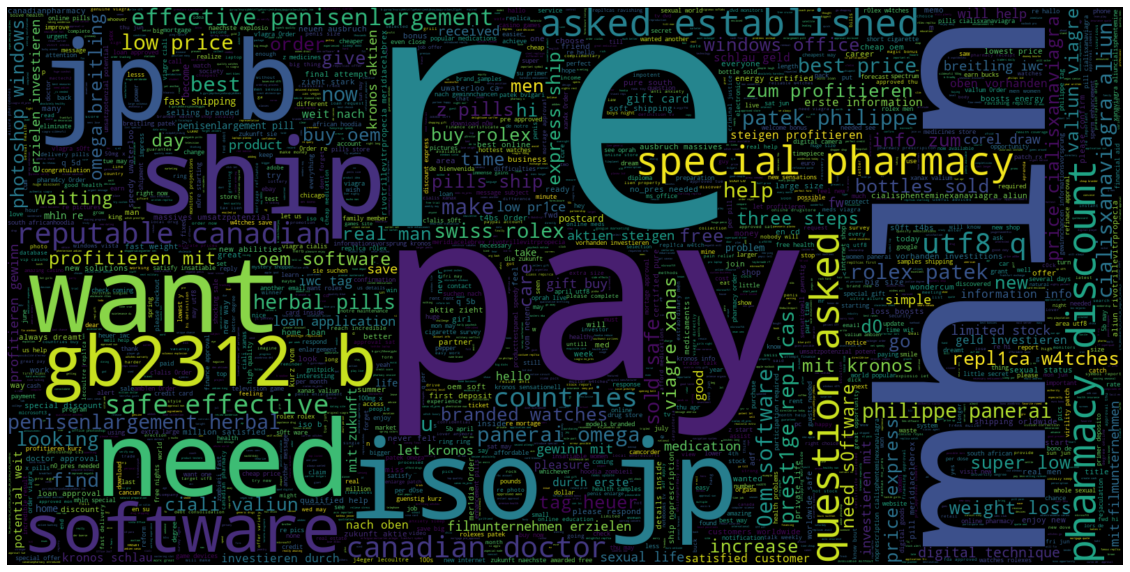

In [ ]:
# Word cloud for spam subjects
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 1].subject_clean))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

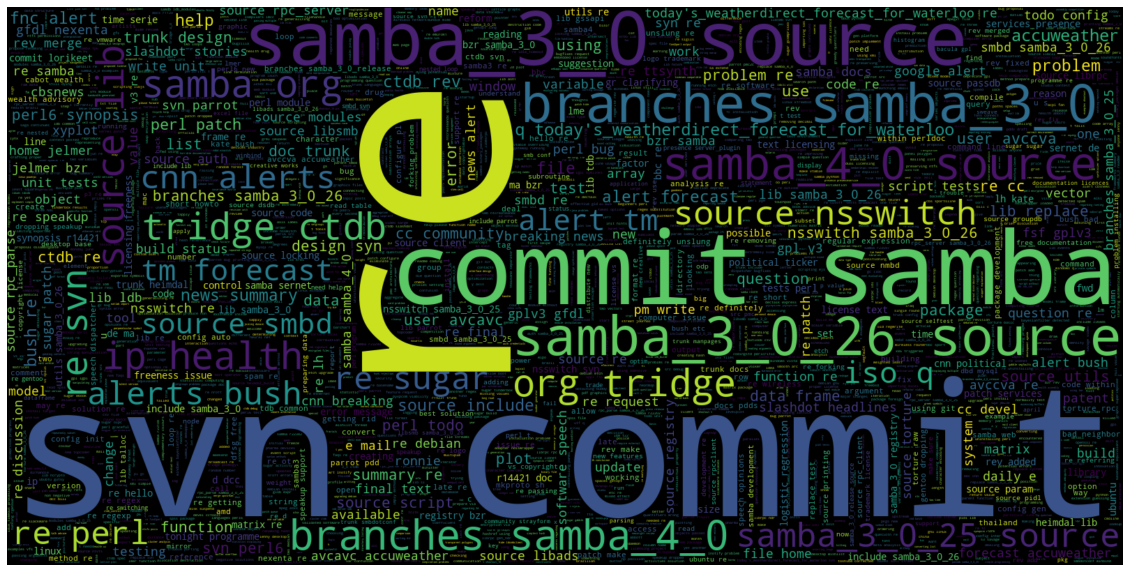

In [ ]:
# Word cloud for not spam subjects
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 0].subject_clean))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")

We can see that there while there are some words in the spam messages and subject lines that overlap with the not-spam messages and subject lines, the most common words are quite different between the two classes. An interesting feature noted was that many spam emails use "Re:" in the subject line to try and trick the user that this is an email they have already responded to before. It is so common that "re" itself shows up quite largely in the spam word cloud!

In [ ]:
# Creating a dataset used for EDA; avoid overwriting
df_exp = df.copy()

In [ ]:
import string 
#Counting letters numbers and punctuation in a string
count = lambda l1,l2: sum([1 for x in l1 if x in l2]) 

In [ ]:
df_exp['msg_len'] = df_exp.message_clean.apply(lambda x: len(x))
df_exp['sub_len'] = df_exp.subject_clean.apply(lambda x: len(x))
df_exp['msg_punc'] = df_exp.message_clean.apply(lambda x: count(x, string.punctuation))
df_exp['sub_punc'] = df_exp.subject_clean.apply(lambda x: count(x, string.punctuation))
df_exp['msg_letters'] = df_exp.message_clean.apply(lambda x: count(x, string.ascii_letters))
df_exp['msg_numbers'] = df_exp.message_clean.apply(lambda x: count(x, string.digits))
df_exp['sub_letters'] = df_exp.subject_clean.apply(lambda x: count(x, string.ascii_letters))
df_exp['sub_numbers'] = df_exp.subject_clean.apply(lambda x: count(x, string.digits))
df_exp.head()

# df['count_punct'] = df.content.apply(lambda s: count(s, string.punctuation))
# str.count : df['comma_count'] = df.string_column.str.count(',')

label                                      message_clean  \
1       0  hi, i've just updated from the gulus and i che...   
3       1  hey billy,   it was really fun going out the o...   
9       0  hi...  i have to use r to find out the 90% con...   
16      1  hey billy,   it was really fun going out the o...   
19      0  hm... sounds like a homework problem to me... ...   

                               subject_clean  \
1                     typo in /debian/readme   
3                       nice talking with ya   
9       [r] confidence-intervals.... help...   
16                                    hi man   
19  re: [r] confidence-intervals.... help...   

                                              content  msg_len  sub_len  \
1   typo in /debian/readme hi, i've just updated f...      728       22   
3   nice talking with ya hey billy,   it was reall...      649       20   
9   [r] confidence-intervals.... help... hi...  i ...      990       36   
16  hi man hey billy,   it was really fun going ou...      649        6   
19  re: [r] confidence-intervals.... help... hm......     1162       40   

    msg_punc  sub_punc  msg_letters  msg_numbers  sub_letters  sub_numbers  
1         52         2          564           10           18            0  
3         25         0          483            3           17            0  
9        116        10          714           23           24            0  
16        25         0          483            3            5            0  
19       139        11          821           13           26            0

In [ ]:
df_exp['label'] = df_exp['label'].astype("category")
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33830 entries, 1 to 75417
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   label          33830 non-null  category
 1   message_clean  33830 non-null  object  
 2   subject_clean  33830 non-null  object  
 3   content        33830 non-null  object  
 4   msg_len        33830 non-null  int64   
 5   sub_len        33830 non-null  int64   
 6   msg_punc       33830 non-null  int64   
 7   sub_punc       33830 non-null  int64   
 8   msg_letters    33830 non-null  int64   
 9   msg_numbers    33830 non-null  int64   
 10  sub_letters    33830 non-null  int64   
 11  sub_numbers    33830 non-null  int64   
dtypes: category(1), int64(8), object(3)
memory usage: 3.1+ MB


In [ ]:
#Descriptive stats of the not-spam records
df_exp[df_exp['label'] == 0].describe()

msg_len       sub_len       msg_punc      sub_punc  \
count   20333.000000  20333.000000   20333.000000  20333.000000   
mean     2188.275414     46.930704     286.814833      4.479565   
std      6019.483730     34.127598     977.035068      5.206510   
min        11.000000      3.000000       0.000000      0.000000   
25%       757.000000     28.000000      74.000000      2.000000   
50%      1221.000000     41.000000     150.000000      3.000000   
75%      2195.000000     60.000000     273.000000      6.000000   
max    671952.000000   1290.000000  100490.000000    135.000000   

         msg_letters   msg_numbers   sub_letters   sub_numbers  
count   20333.000000  20333.000000  20333.000000  20333.000000  
mean     1426.905572     86.345104     34.635224      1.844194  
std      4017.813575    367.943907     24.167954      3.967966  
min         8.000000      0.000000      1.000000      0.000000  
25%       488.000000      9.000000     21.000000      0.000000  
50%       810.000000     27.000000     31.000000      0.000000  
75%      1407.000000     73.000000     43.000000      3.000000  
max    471476.000000  21674.000000   1054.000000     89.000000

In [ ]:
#Descriptive stats of the spam records
df_exp[df_exp['label'] == 1].describe()

msg_len       sub_len      msg_punc      sub_punc    msg_letters  \
count   13497.000000  13497.000000  13497.000000  13497.000000   13497.000000   
mean      994.537082     40.031637     56.611321      1.930948     702.416092   
std      2175.096508     33.505493    102.613387      3.160727    1665.085213   
min         1.000000      1.000000      0.000000      0.000000       0.000000   
25%       334.000000     20.000000     15.000000      0.000000     225.000000   
50%       645.000000     32.000000     31.000000      1.000000     444.000000   
75%      1240.000000     51.000000     68.000000      2.000000     910.000000   
max    141935.000000    755.000000   4045.000000     58.000000  111912.000000   

        msg_numbers   sub_letters   sub_numbers  
count  13497.000000  13497.000000  13497.000000  
mean      35.234200     31.076684      1.456250  
std       86.010645     25.729012      4.550875  
min        0.000000      0.000000      0.000000  
25%        3.000000     16.000000      0.000000  
50%       11.000000     25.000000      0.000000  
75%       35.000000     39.000000      1.000000  
max     4499.000000    334.000000    208.000000

We can see that numerically, the features between the two classes are quite different. This can be visualised further using KDE plots.

In [ ]:
import seaborn as sns 

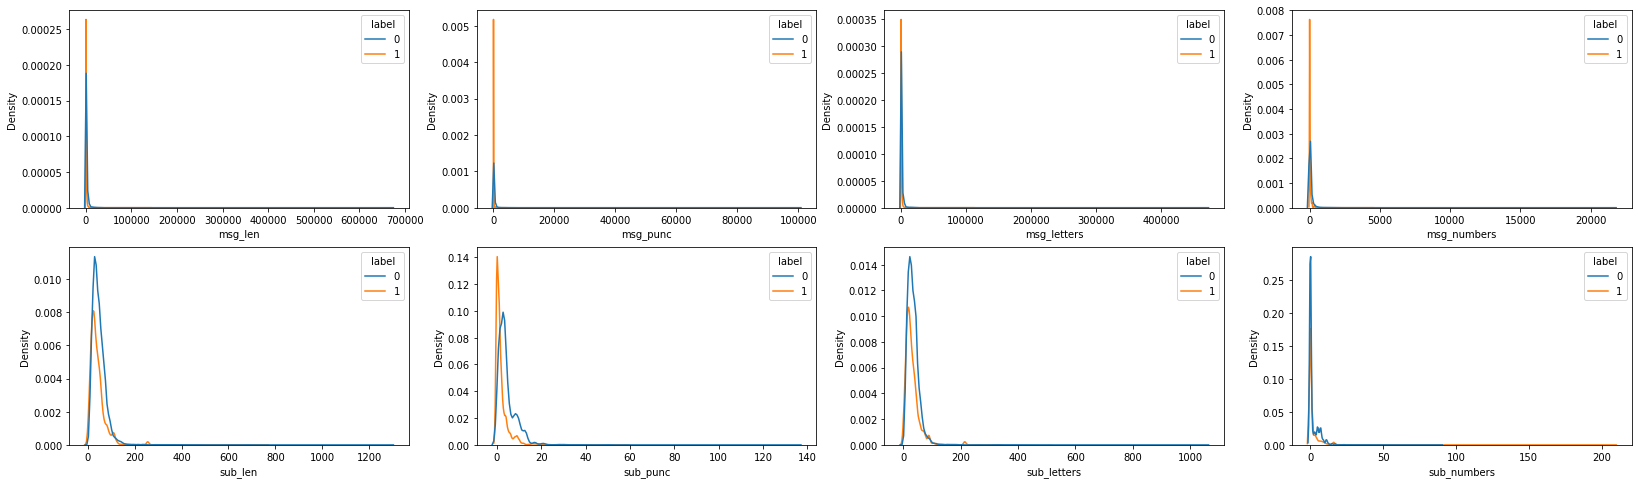

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (28,8))
sns.kdeplot(data=df_exp, x="msg_len", hue="label", ax=axes[0][0])
sns.kdeplot(data=df_exp, x="msg_punc", hue="label", ax=axes[0][1])
sns.kdeplot(data=df_exp, x="msg_letters", hue="label", ax=axes[0][2])
sns.kdeplot(data=df_exp, x="msg_numbers", hue="label", ax=axes[0][3])
sns.kdeplot(data=df_exp, x="sub_len", hue="label", ax=axes[1][0])
sns.kdeplot(data=df_exp, x="sub_punc", hue="label", ax=axes[1][1])
sns.kdeplot(data=df_exp, x="sub_letters", hue="label", ax=axes[1][2])
sns.kdeplot(data=df_exp, x="sub_numbers", hue="label", ax=axes[1][3])

It is found that there are messages and subjects with a significant length, yet contain no ASCII characters in the `msg_letters` or `sub_letters` column. We investigate this to determine if there is unuseable data present in the dataset, which may contain emails with contents that cannot be read.

In [ ]:
df_exp[(df_exp['msg_letters'] == 0) | (df_exp['sub_letters'] == 0)].head()

label                                      message_clean  \
51        1  ×ð¾´µä¹ó¹«ë¾áìµ¼/²æîñ£ºäúºã£¡     îòêçéîã¯£¨éî...   
8481      1  äúºã£¡ ¡¡¡¡ ¡¡¡¡±¾¹«ë¾³éá¢¶àäêóð×åá¼ºãµäéç»á¹ø...   
11104     1  ïèéúäúºã£ºîòë¾óå»ý´ú¿ª½¨öþ°²×°¡¢æû³µðþàí¡¢ôëêä...   
14266     1  have you ever wished you ejaculate like a porn...   
16828     1  ·ð  é½  êð  ìú  ïè  êµ  òµ  óð  ïþ  ¹«  ë¾    ...   

                       subject_clean  \
51     =?gb2312?b?sk7wrrzso6gjoq==?=   
8481       =?gb2312?b?xvpstc+y0by=?=   
11104      =?gb2312?b?tpq/qreixre=?=   
14266                              :   
16828      =?gb2312?b?0rxo8ceiycwh?=   

                                                 content  msg_len  sub_len  \
51     =?gb2312?b?sk7wrrzso6gjoq==?= ×ð¾´µä¹ó¹«ë¾áìµ¼...      685       29   
8481   =?gb2312?b?xvpstc+y0by=?= äúºã£¡ ¡¡¡¡ ¡¡¡¡±¾¹«...      440       25   
11104  =?gb2312?b?tpq/qreixre=?= ïèéúäúºã£ºîòë¾óå»ý´ú...      184       25   
14266  : have you ever wished you ejaculate like a po...      416        1   
16828  =?gb2312?b?0rxo8ceiycwh?= ·ð  é½  êð  ìú  ïè  ...     1213       25   

       msg_punc  sub_punc  msg_letters  msg_numbers  sub_letters  sub_numbers  
51            4         8            0           13           15            6  
8481          1         8            0           11           12            5  
11104         0         8            0           23           13            4  
14266        40         1          300            7            0            0  
16828       109         6            0           34           13            6

It seems that there are messages and subjects that do not contain characters that are readable. We can remove these from the dataset as well, as they will not be able to be encoded properly. 

In [ ]:
drop_idx = df_exp[(df_exp['msg_letters'] == 0) | (df_exp['sub_letters'] == 0)].index.tolist()
df_exp.drop(index = drop_idx, inplace=True)

In [ ]:
df.drop(index = drop_idx, inplace=True)
print(df.shape)

(33766, 4)


In [ ]:
print(drop_idx)
print('\n', df.shape)

[51, 8481, 11104, 14266, 16828, 16898, 17249, 19380, 19381, 19528, 20917, 21641, 22898, 23606, 23719, 23742, 25674, 26101, 28204, 28643, 29065, 31653, 33486, 33820, 34507, 36415, 36659, 37302, 37836, 37898, 38014, 38403, 38651, 38806, 41922, 42539, 44063, 46184, 46410, 48517, 48807, 48972, 49669, 49686, 50148, 50391, 52594, 53719, 54812, 55253, 58166, 58589, 58858, 59023, 59099, 60890, 61794, 61934, 63502, 64929, 66530, 69224, 70118, 75270]

 (33766, 4)


We once again look at the distribution of these features after removing the unuseable records.

In [ ]:
df_exp[df_exp['label'] == 0].describe()

msg_len       sub_len       msg_punc      sub_punc  \
count   20333.000000  20333.000000   20333.000000  20333.000000   
mean     2188.275414     46.930704     286.814833      4.479565   
std      6019.483730     34.127598     977.035068      5.206510   
min        11.000000      3.000000       0.000000      0.000000   
25%       757.000000     28.000000      74.000000      2.000000   
50%      1221.000000     41.000000     150.000000      3.000000   
75%      2195.000000     60.000000     273.000000      6.000000   
max    671952.000000   1290.000000  100490.000000    135.000000   

         msg_letters   msg_numbers   sub_letters   sub_numbers  
count   20333.000000  20333.000000  20333.000000  20333.000000  
mean     1426.905572     86.345104     34.635224      1.844194  
std      4017.813575    367.943907     24.167954      3.967966  
min         8.000000      0.000000      1.000000      0.000000  
25%       488.000000      9.000000     21.000000      0.000000  
50%       810.000000     27.000000     31.000000      0.000000  
75%      1407.000000     73.000000     43.000000      3.000000  
max    471476.000000  21674.000000   1054.000000     89.000000

In [ ]:
df_exp[df_exp['label'] == 1].describe()

msg_len       sub_len      msg_punc      sub_punc    msg_letters  \
count   13433.000000  13433.000000  13433.000000  13433.000000   13433.000000   
mean      996.961587     40.108613     56.776148      1.918187     705.614680   
std      2179.852026     33.554018    102.807419      3.153379    1668.395032   
min         1.000000      1.000000      0.000000      0.000000       1.000000   
25%       336.000000     20.000000     15.000000      0.000000     227.000000   
50%       647.000000     33.000000     31.000000      1.000000     445.000000   
75%      1242.000000     51.000000     68.000000      2.000000     915.000000   
max    141935.000000    755.000000   4045.000000     58.000000  111912.000000   

        msg_numbers   sub_letters   sub_numbers  
count  13433.000000  13433.000000  13433.000000  
mean      35.340207     31.174421      1.444205  
std       86.198480     25.740441      4.552621  
min        0.000000      1.000000      0.000000  
25%        3.000000     16.000000      0.000000  
50%       11.000000     25.000000      0.000000  
75%       36.000000     39.000000      1.000000  
max     4499.000000    334.000000    208.000000

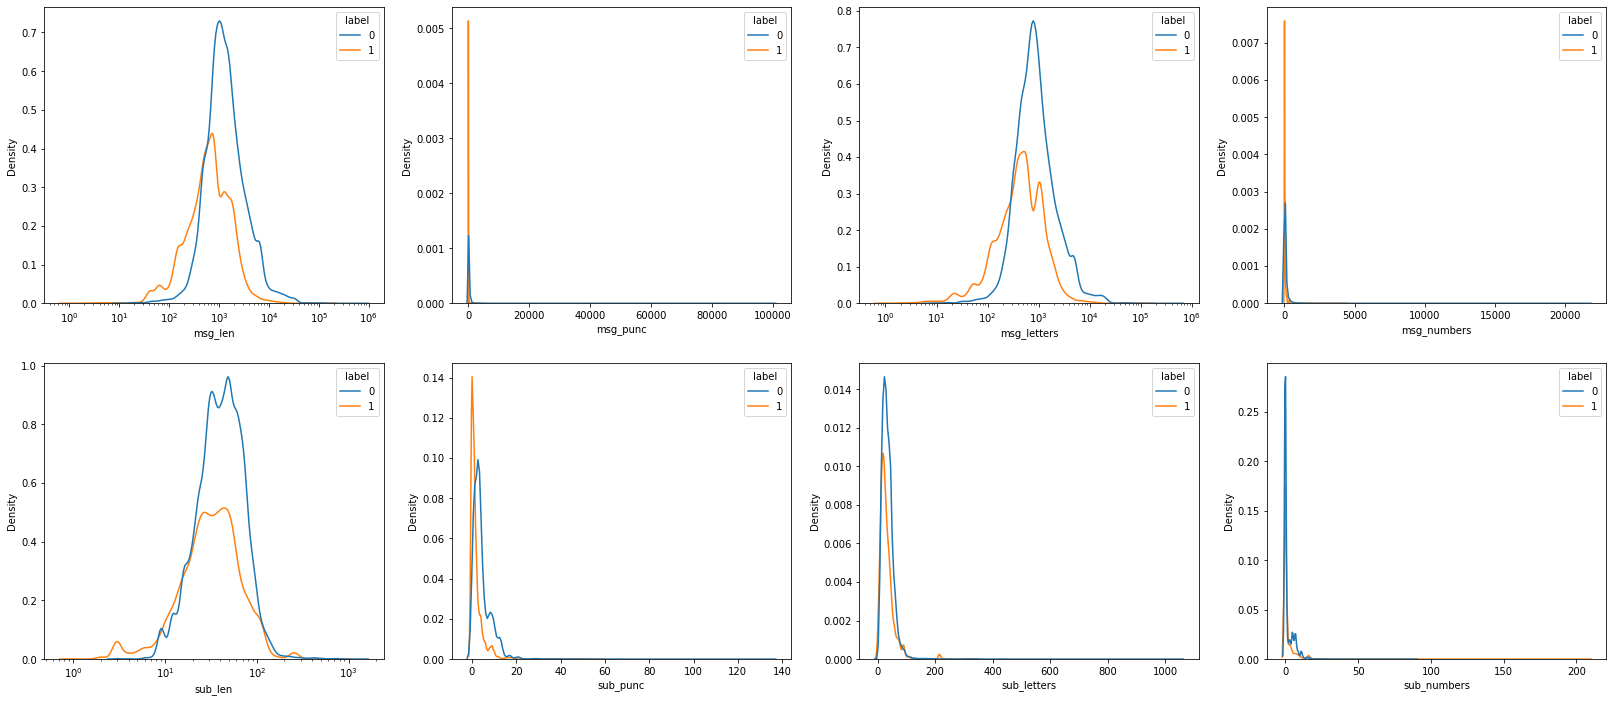

In [ ]:
#New distrubution after dropping rows with no ascii characters
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (28,12))
sns.kdeplot(data=df_exp, x="msg_len", hue="label", ax=axes[0][0], log_scale=True)
sns.kdeplot(data=df_exp, x="msg_punc", hue="label", ax=axes[0][1])
sns.kdeplot(data=df_exp, x="msg_letters", hue="label", ax=axes[0][2], log_scale=True)
sns.kdeplot(data=df_exp, x="msg_numbers", hue="label", ax=axes[0][3])
sns.kdeplot(data=df_exp, x="sub_len", hue="label", ax=axes[1][0], log_scale=True)
sns.kdeplot(data=df_exp, x="sub_punc", hue="label", ax=axes[1][1])
sns.kdeplot(data=df_exp, x="sub_letters", hue="label", ax=axes[1][2])
sns.kdeplot(data=df_exp, x="sub_numbers", hue="label", ax=axes[1][3])

**Findings:**

* There is significant overlap in the distributions between the numerical features of the messages and subjects, and would likely make differentiating them without using their textual contexts very difficult.
* There is a very wide distribution in message and subject length, punctuation counts, and the number of ASCII letters and numbers across both classes of emails. The vast majority of message lengths are concentrated are around 1000 in character length; whilst the majority of email subject line are between 100 to 1000 in characters in length.
* Punctuation and numeric characters have a very wide range, but are concentrated on the lower end for both classes (for both message and subject).



---




# Preparation for Model Training - Machine Learning Methods
We will use NLP preprocessing steps to prepare the textual data in a way that will allow it to be used to train some basic machine learning models. We will create several classification models to train and test the data we have used. 

Note that a small fraction of the entire dataset will be used in lieu of the entire dataset itself. This is because huge dataset sizes can be inefficient to train in a time-effective manner. 

We will use the contents of the `message_clean` column as the solve X-variable, though using the combined `content` column is also possible. The `message_clean` column is chosen for the sake of efficiency in training, as longer strings will later require much more computational power when implementing an LSTM.

In [ ]:
dfml = df.sample(frac=0.30)
dfml.shape

(10130, 4)

We will use 15% of the entire dataframe for the dataset of the ML model. More or less can be taken by changing the fraction in the above code block. A small sample is taken due to limited computational resources.

Since we are only using the `message_clean` column for the X variables, we can drop the two other columns `subject_clean` and `content`. Note that any of these three columns could be used to conduct the same text classification and their results can be compared.

In [ ]:
# Understand the ratio of data 
dfml.label.value_counts(normalize=True) * 100

0    60.256663
1    39.743337
Name: label, dtype: float64

The dataset consists of about 40% of spam emails, and the remaining 60% are not spam. This is not too imbalanced so dataset balancing methods will not be used.

We will use stemming and remove stop words from the text in `message_clean`. After this, we will use `TfidfVectorizer` to vectorize the textual data.

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
port_stem = PorterStemmer()

In [ ]:
def stemming(content):
    remove_punc_content = re.sub('[^0-9a-zA-Z]+', ' ', content)
    split_content = remove_punc_content.split()
    stemmed_content = [port_stem.stem(word) for word in split_content if word not in stopwords.words('english')]
    joined_stemmed = ' '.join(stemmed_content)
    return joined_stemmed

In [ ]:
dfml.drop(columns = ['subject_clean', 'content'], inplace=True)

In [ ]:
import nltk
nltk.download('stopwords')

dfml['message_clean_stem'] = dfml['message_clean'].apply(stemming)
dfml.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


label                                      message_clean  \
27286      0  hi all,  i'm new to writing object oriented pe...   
74422      1  hello! i am bored tonight. i am nice girl that...   
44702      1                                                 th   
11225      1  this one is being promoted, take advantage spe...   
17752      0  on 4/23/2007 10:56 am, sebastian weber wrote: ...   

                                      message_clean_stem  
27286  hi new write object orient perl hope advic fou...  
74422  hello bore tonight nice girl would like chat e...  
44702                                                 th  
11225  one promot take advantag special situat alert ...  
17752  4 23 2007 10 56 sebastian weber wrote hello ev...

In [ ]:
# Get the X and y values
X = dfml['message_clean_stem'].values
y = dfml['label'].values

In [ ]:
print(X[0])

hi new write object orient perl hope advic found need use imag magick tonight order reus code futur put packag sub thought seem like good opportun tri write oo modul howev sure better make use inherit although sure also look suggest cut version code goe like usr bin perl use strict use warn use carp error obj imag obj imag mi common imag magick new path home nigel script taylor1 jpg obj imag resiz geometri 360 obj imag crop geometri 360x480 obj imag output path home nigel script taylor thumbnail jpg packag mi common imag magick use imag magick sub new class data data imag magick object imag magick new error data imag magick object read data path croak error error return bless data class sub output self arg error self imag magick object write arg path croak error error sub resiz self arg error self imag magick object resiz geometri arg geometri croak error error sub crop self arg error self imag magick object crop geometri arg geometri croak error error could better tia cheer nigel unsu

In [ ]:
print(y)

[0 1 1 ... 0 1 1]


In [ ]:
# Vectorize the text using TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.fit_transform(X)

In [ ]:
X.shape

(10130, 65801)

In [ ]:
print(X[0])
print(type(X))
print(X.shape)

  (0, 38918)	0.02071906432242818
  (0, 34338)	0.008651339771260145
  (0, 33565)	0.012868091989661523
  (0, 22556)	0.020042135644978795
  (0, 15068)	0.020342795760269438
  (0, 46295)	0.03387649192577376
  (0, 18394)	0.04617471668490299
  (0, 40651)	0.02331396982209901
  (0, 61705)	0.03450153630865074
  (0, 21485)	0.02745521684370115
  (0, 59516)	0.0420517870253727
  (0, 23347)	0.01711620039327757
  (0, 16753)	0.2004952155051751
  (0, 54469)	0.09694364250073585
  (0, 19130)	0.039516028826062234
  (0, 52280)	0.02026156625774432
  (0, 23688)	0.2047276671756035
  (0, 51259)	0.01447283993946535
  (0, 24411)	0.09181778326036133
  (0, 21933)	0.052064084676573516
  (0, 59496)	0.05538949528737855
  (0, 58569)	0.04418486097096416
  (0, 46527)	0.052622745047093675
  (0, 9223)	0.0578507709249038
  (0, 23715)	0.13458008602394222
  :	:
  (0, 32213)	0.020659127166640725
  (0, 39463)	0.02975666651738489
  (0, 54400)	0.021272242169200994
  (0, 59447)	0.025235540850635892
  (0, 57548)	0.14604145378692424

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2,
                                                   random_state=0,
                                                   stratify=y)

## Logistic Regression Classification Model

We will make a logistic regression model as the first of the machine learning models to classify the text as spam or not spam. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
LR_model = LogisticRegression()

In [ ]:
LR_model.fit(X_train, y_train)



LogisticRegression()

In [ ]:
LR_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
LR_ypred = LR_model.predict(X_test)

In [ ]:
def evalmetrics(ytest, ypred):
    acc = accuracy_score(ytest, ypred) * 100
    print(classification_report(ytest, ypred))
    print('\n', 'Accuracy = {:0.2f}%.'.format(acc))
    ConfusionMatrixDisplay.from_predictions(ytest, ypred)
    return 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1221
           1       0.99      1.00      0.99       805

    accuracy                           0.99      2026
   macro avg       0.99      0.99      0.99      2026
weighted avg       0.99      0.99      0.99      2026


 Accuracy = 99.31%.


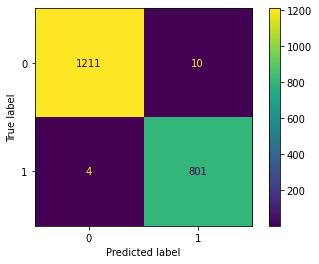

In [ ]:
# Evaulating the performance of the Logistic Regression model
evalmetrics(y_test, LR_ypred)

In [ ]:
#cross-validation of logistic regression
score_LR_model=cross_val_score(LR_model, X_train, y_train,cv=10, scoring='accuracy')
print(score_LR_model)
print("Avg :",np.average(score_LR_model))


[0.99630086 0.98890259 0.99260173 0.99753391 0.99012346 0.9962963
 0.99012346 0.99382716 0.98765432 0.99506173]
Avg : 0.9928425507299327


## Naive Bayes Classification Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB_model = MultinomialNB().fit(X_train, y_train)

In [ ]:
NB_model.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [ ]:
NB_ypred = NB_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1221
           1       1.00      0.94      0.97       805

    accuracy                           0.98      2026
   macro avg       0.98      0.97      0.97      2026
weighted avg       0.98      0.98      0.98      2026


 Accuracy = 97.53%.


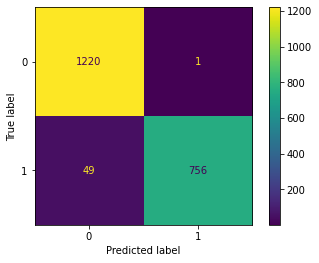

In [ ]:
evalmetrics(y_test, NB_ypred)

In [ ]:
#cross-validation of Naive Bayes Classification Model
score_NB_model=cross_val_score(NB_model, X_train, y_train,cv=10, scoring='accuracy')
print(score_NB_model)
print("Avg :",np.average(score_NB_model))

[0.9864365  0.97410604 0.96300863 0.97657213 0.97777778 0.97777778
 0.9654321  0.9691358  0.97407407 0.97283951]
Avg : 0.9737160341599305


### Support Vector Machine Classification Model

In [ ]:
from sklearn.svm import SVC
SVC_model = SVC()

In [ ]:
SVC_model.fit(X_train, y_train)

SVC()

In [ ]:
SVC_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
SVC_ypred = SVC_model.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1221
           1       1.00      0.99      0.99       805

    accuracy                           1.00      2026
   macro avg       1.00      0.99      0.99      2026
weighted avg       1.00      1.00      1.00      2026


 Accuracy = 99.51%.


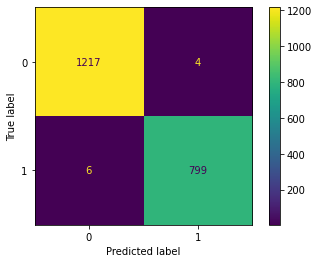

In [ ]:
evalmetrics(y_test, SVC_ypred)

In [ ]:
#cross-validation of Support Vector Machine Classification Model
score_SVC_model=cross_val_score(SVC_model, X_train, y_train,cv=10, scoring='accuracy')
print(score_SVC_model)
print("Avg :",np.average(score_SVC_model))

[0.99630086 0.99260173 0.99506782 0.99630086 0.99506173 0.99753086
 0.99259259 0.9962963  0.99012346 0.99753086]
Avg : 0.9949407072506127


## Results from Machine Learning 

The results demonstrate that machine learning models are able to distinguish and classify emails as spam or not spam at a high level of accuracy. The best performing method was the Support Vector Classifier at 99.31% accuracy, whilst the Logistic Regression also provided 98.92% accuracy. Naive Bayes performed just marginally poorer at 96.65%, but is still a very high level of accuracy.

# Deep Learning Methods

Despite the very high level of accuracy achieved by common machine learning classification models, one might be interested in attempting to build a classification model using neural networks. For this section of the project, a very simple artificial neural network (ANN) will be created, as well as an LSTM. Note that the computational time is significantly higher for an LSTM, and it could potentially be difficult to optimise these networks as well without access to GPU/CPU. 

## Artificial Neural Network (ANN) Classifier

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
import os
from keras import regularizers

In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard

# create subdirectory to visualize EarlyStopping  in tensorboard
logdir = os.path.join("logs", "EarlyStopping-Loss")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Adding EarlyStopping call back
stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3)

We will continue to use the cleaned and stemmed message column (`message_clean_stem`) from the dataframe `dfml` for this section of the project. We will re-initialise the `X` and `y` values, as they will be processed in a different way using `CountVectorizer` instead. 

In [ ]:
dfml.head()

label                                      message_clean  \
27286      0  hi all,  i'm new to writing object oriented pe...   
74422      1  hello! i am bored tonight. i am nice girl that...   
44702      1                                                 th   
11225      1  this one is being promoted, take advantage spe...   
17752      0  on 4/23/2007 10:56 am, sebastian weber wrote: ...   

                                      message_clean_stem  
27286  hi new write object orient perl hope advic fou...  
74422  hello bore tonight nice girl would like chat e...  
44702                                                 th  
11225  one promot take advantag special situat alert ...  
17752  4 23 2007 10 56 sebastian weber wrote hello ev...

In [ ]:
messages = dfml['message_clean_stem'].values
y = dfml['label'].values

In [ ]:
messages_train, messages_test, y_train, y_test = train_test_split(messages, y,
                                                                 test_size = 0.2,
                                                                 random_state=0,
                                                                 stratify=y)

In [ ]:
countVectorizer = CountVectorizer() #has lots of parameters we could use, max/min_df; n_gram, stop_words
countVectorizer.fit(messages_train)
X_train = countVectorizer.transform(messages_train)
X_test = countVectorizer.transform(messages_test)
X_train

<8104x58143 sparse matrix of type '<class 'numpy.int64'>'
	with 759059 stored elements in Compressed Sparse Row format>

In [ ]:
#Check types of each train and test
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


You may run into a problem trying to use a sparse matrix as an input into the neural network. We change it into a numpy array beforehand.

In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8104, 58143) (8104,) (2026, 58143) (2026,)


In [ ]:
from keras.models import Sequential
from keras import layers

In [ ]:
input_dim = X_train.shape[1]

In [ ]:
X_train.shape

(8104, 58143)

In [ ]:
model = Sequential()
model.add(layers.Dense(10, kernel_regularizer=regularizers.l2(l2=0.01),input_dim=input_dim, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                581440    
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 581,451
Trainable params: 581,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    epochs = 20,
                    verbose = False,
                    validation_data = (X_test, y_test),
                    batch_size = 1000,
                    callbacks=[tensorboard_callback, stop])

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9973
Testing Accuracy:  0.9891


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

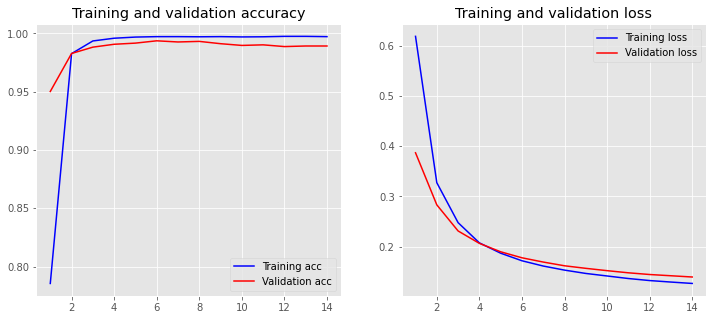

In [ ]:
plot_history(history)

## Results from ANN Classification model

The results demonstrate that a very simple artificial neural network is capable of achieving very high accuracy, with a training accuracy of 99.98% and a testing accuracy of 99.21%. This is model could be further developed to include dropout layers and additional layers to improve it further. There is still a risk of model overfitting or not being highly generalisable. 

## LSTM Classification Model

In addition to the ANN, another deep learning model know as an LSTM is used to create another classification model. Before we start building the LSTM, it is important to understand some of the characteristics of our textual data to make better informed choices to the parameters used within the LSTM. 

In [ ]:
import tensorflow as tf
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import os
from keras import regularizers

In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard

# create subdirectory to visualize EarlyStopping  in tensorboard
logdir = os.path.join("logs", "EarlyStopping-Loss")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Adding EarlyStopping call back
stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3)

In [ ]:
dfml_exp = dfml.copy()

In [ ]:
dfml_exp['approx_word_count'] = dfml_exp['message_clean_stem'].apply(lambda x: count(x, ' '))
dfml_exp.describe()

label  approx_word_count
count  10130.000000       10130.000000
mean       0.397433         194.991017
std        0.489391        1044.994399
min        0.000000           0.000000
25%        0.000000          57.000000
50%        0.000000         106.000000
75%        1.000000         200.000000
max        1.000000       98619.000000

In [ ]:
dfml_exp[dfml_exp['approx_word_count'] < 525].count()

label                 9572
message_clean         9572
message_clean_stem    9572
approx_word_count     9572
dtype: int64

For this fraction of the dataset that was taken, we find there are approximately 191 words (denoted by the number of spaces found in the emails). About 93% of the emails contain 525 or fewer spaces, which indicates there are typically less than 525 words long at most. This information can be used to set the maximum sequence length for the LSTM.

LSTM will use a different preprocessing step, which will not only remove all punctuation and non-alphanumeric characters, but also remove links and emails inside the message contents. This is done below.

In [ ]:
stop_words = stopwords.words('english')
snow_stem = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def text_cleaning(text):
    text = re.sub(text_cleaning_re, ' ', str(text)).strip()
    split_content = text.split()
    stemmed_content = [snow_stem.stem(word) for word in split_content if word not in stopwords.words('english')]
    joined_stemmed = ' '.join(stemmed_content)
    return joined_stemmed

In [ ]:
dfml['message_clean_stem_dl'] = dfml['message_clean'].apply(lambda x: text_cleaning(x))
dfml.head()

label                                      message_clean  \
27286      0  hi all,  i'm new to writing object oriented pe...   
74422      1  hello! i am bored tonight. i am nice girl that...   
44702      1                                                 th   
11225      1  this one is being promoted, take advantage spe...   
17752      0  on 4/23/2007 10:56 am, sebastian weber wrote: ...   

                                      message_clean_stem  \
27286  hi new write object orient perl hope advic fou...   
74422  hello bore tonight nice girl would like chat e...   
44702                                                 th   
11225  one promot take advantag special situat alert ...   
17752  4 23 2007 10 56 sebastian weber wrote hello ev...   

                                   message_clean_stem_dl  
27286  hi new write object orient perl hope advic fou...  
74422  hello bore tonight nice girl would like chat e...  
44702                                                 th  
11225  one promot take advantag special situat alert ...  
17752  4 23 2007 10 56 sebastian weber wrote hello ev...

In [ ]:
max_sequence_length = 525

In [ ]:
train_data, test_data = train_test_split(dfml, 
                                        test_size = 0.2,
                                        random_state=0)
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 8104
Test data size: 2026


In [ ]:
train_data.head()

label                                      message_clean  \
9551       0  man charged with murder, arson in illinois fir...   
30557      1  oem means original equipment manufacturer. so ...   
28533      0  thanks very much for your help.  i remain puzz...   
31508      0  doubling the length of the data doubles the ap...   
65335      0  on monday 25 june 2007 13:26, bill wheeler wro...   

                                      message_clean_stem  \
9551   man charg murder arson illinoi fire kill 5 chi...   
30557  oem mean origin equip manufactur oem synonym l...   
28533  thank much help remain puzzl origin behavior r...   
31508  doubl length data doubl appar number observ wo...   
65335  monday 25 june 2007 13 26 bill wheeler wrote w...   

                                   message_clean_stem_dl  
9551   man charg murder arson illinoi fire kill 5 chi...  
30557  oem mean origin equip manufactur oem synonym l...  
28533  thank much help remain puzzl origin behavior r...  
31508  doubl length data doubl appar number observ wo...  
65335  monday 25 june 2007 13 26 bill wheeler wrote w...

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.message_clean_stem_dl)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1 
print("Vocabularly size:", vocab_size)

Vocabularly size: 51195


In [ ]:
#Pad sequences will make the text in messages all the same size 
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data.message_clean_stem_dl),
                        maxlen = max_sequence_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data.message_clean_stem_dl),
                       maxlen = max_sequence_length)

print("Training X Shape:", X_train.shape)
print("Testing X Shape:", X_test.shape)

Training X Shape: (8104, 525)
Testing X Shape: (2026, 525)


In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.label.to_list())

y_train = encoder.transform(train_data.label.to_list())
y_test = encoder.transform(test_data.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (8104, 1)
y_test shape: (2026, 1)


In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks/Riya_DL_Project'

In [ ]:
GLOVE_EMB = './glove.6B.300d.txt'   #the corpus for the pre-trained word vectors. GloVe is an unsupervised learning algorithm for obtaining vector representations for words.
EMBEDDING_DIM = 300
LR = 1e-2                  #change from 1e-3
BATCH_SIZE = 512           #change from 1024
EPOCHS = 10
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/Riya_DL_Project/best_model.hdf5" #That file is the one we save, not a file you need beforehand

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM)) #The numpy.zeros() function returns a new array of given shape and type, with zeros.
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) #get() Method return the value for the given key if present in the dictionary. If not, then it will return None (if get() is used with only one argument
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length= max_sequence_length,
                                          trainable=False)

In [ ]:
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from keras.layers import SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
# ReduceLROnPlateau is not always necessary, we can use it and then check our 
# loss during training and validation and see if it's necessary 
# Early Stopping may be a bit more useful in our case ?

In [ ]:
sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, kernel_regularizer=regularizers.l2(l2=0.01), activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512,kernel_regularizer=regularizers.l2(l2=0.01), activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)


# 64 = 2^6
# 512 = 2^9
# Could change to 32 and 128 (2^5 and 2^7 respectively)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 525)]             0         
                                                                 
 embedding (Embedding)       (None, 525, 300)          15358500  
                                                                 
 spatial_dropout1d (SpatialD  (None, 525, 300)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 521, 64)           96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 512)               66048 

In [ ]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])

ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,         #Reduce learning rate when a metric has stopped improving.
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [ ]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")
#the computational time is significantly higher for an LSTM, 
#and it could potentially be difficult to optimise these networks as well without access to GPU/CPU.

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on CPU...


In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau, stop])

Epoch 1/10
16/16 [==============================] - 219s 13s/step - loss: 1.9831 - accuracy: 0.7887 - val_loss: 0.7596 - val_accuracy: 0.9571 - lr: 0.0100
Epoch 2/10
16/16 [==============================] - 205s 13s/step - loss: 0.3700 - accuracy: 0.9667 - val_loss: 0.2014 - val_accuracy: 0.9748 - lr: 0.0100
Epoch 3/10
16/16 [==============================] - 207s 13s/step - loss: 0.1519 - accuracy: 0.9790 - val_loss: 0.1195 - val_accuracy: 0.9793 - lr: 0.0100
Epoch 4/10
16/16 [==============================] - 205s 13s/step - loss: 0.0931 - accuracy: 0.9859 - val_loss: 0.0912 - val_accuracy: 0.9817 - lr: 0.0100
Epoch 5/10
16/16 [==============================] - 206s 13s/step - loss: 0.0736 - accuracy: 0.9886 - val_loss: 0.1019 - val_accuracy: 0.9837 - lr: 0.0100
Epoch 6/10
16/16 [==============================] - 205s 13s/step - loss: 0.0607 - accuracy: 0.9894 - val_loss: 0.0720 - val_accuracy: 0.9886 - lr: 0.0100
Epoch 7/10
16/16 [==============================] - 203s 13s/step - lo

In [ ]:
model.save('test_model_r.h5')

In [ ]:
# from keras.models import load_model
# model = load_model('best_model.hdf5')

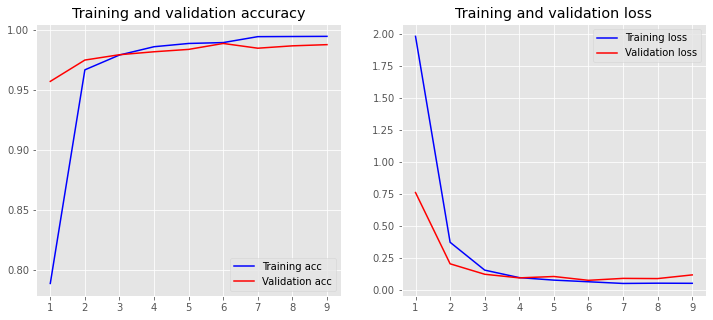

In [ ]:
plot_history(history)

In [ ]:
def decode_spam(score):
    return 1 if score>0.5 else 0

scores = model.predict(X_test, verbose=1, batch_size=10000)
y_pred_lstm = [decode_spam(score) for score in scores]

1/1 [==============================] - 11s 11s/step


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1241
           1       0.98      0.98      0.98       785

    accuracy                           0.99      2026
   macro avg       0.99      0.99      0.99      2026
weighted avg       0.99      0.99      0.99      2026


 Accuracy = 98.77%.


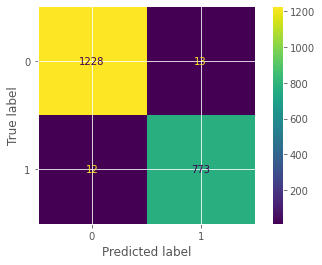

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1241
           1       0.98      0.98      0.98       785

    accuracy                           0.99      2026
   macro avg       0.99      0.99      0.99      2026
weighted avg       0.99      0.99      0.99      2026


 Accuracy = 98.77%.


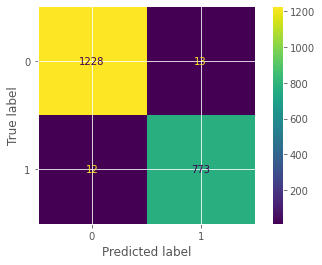

In [ ]:
evalmetrics(y_test, y_pred_lstm)